# CPSC 330 - Applied Machine Learning 

## Homework 5: Evaluation metrics
### Associated lectures: [Lectures 9, 10](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday, Feb 27, 2023 at 11:59pm**

## Imports

In [1]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    mean_absolute_percentage_error,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Instructions 
<hr>
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has cancer or not. It is important to catch this disease early to reduce mortality rate; late diagnosis will result in metastasis to other organs, which adversely impacts patient's prognosis. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|         | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 48 | 32 |
| **Actual no disease**       | 20 | 100 |


- Model B

|        | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 43 | 22 |
| **Actual no disease**       | 35 | 100 |

### 1.1 Positive vs. negative class 
rubric={points:2}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

**ANS:** I would consider the class of having the disease to be positive. This is because we are trying to spot if the patient has cancer, so it would be positive to identify the disease.

<br><br>

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [2]:
results_dict = {"A": {}, "B": {}}

In [3]:
A_TP = 48
A_TN = 100
A_FP = 20
A_FN = 32

B_TP = 43
B_TN = 100
B_FP = 35
B_FN = 22

In [4]:
results_dict["A"]["accuracy"] = (A_TP + A_TN)/(A_TP + A_TN + A_FP + A_FN)
results_dict["B"]["accuracy"] = (B_TP + B_TN)/(B_TP + B_TN + B_FP + B_FN)

<br><br>

### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

**ANS:** Based on the accuracy metric, I would pick model A as it has a higher accuracy score, meaning it more often makes the proper diagnoses

<br><br>

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [5]:
results_dict["A"]["precision"] = A_TP/(A_TP+A_FP)
results_dict["B"]["precision"] = B_TP/(B_TP+B_FP)
results_dict["A"]["recall"] = A_TP/(A_TP+A_FN)
results_dict["B"]["recall"] = B_TP/(B_TP+B_FN)

A_prec = results_dict["A"]["precision"]
B_prec = results_dict["B"]["precision"]
A_recall = results_dict["A"]["recall"]
B_recall = results_dict["B"]["recall"]

results_dict["A"]["f1"] = 2 * (A_prec * A_recall)/(A_prec + A_recall)
results_dict["B"]["f1"] = 2 * (B_prec * B_recall)/(B_prec + B_recall)

Show the dataframe with all results. 

In [6]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.740000,0.715000
precision,0.705882,0.551282
recall,0.600000,0.661538
f1,0.648649,0.601399


<br><br>

### 1.5 Discussion
rubric={points:4}

**Your tasks:**
1. Given the type of problem (early cancer diagnosis), which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

**ANS:** Since it is more important for us to diagnose the disease early on, this means we would want to reduce the false negatives and detect more positives. Thus, the recall metric is more important in this problem as recall represents how many positive examples we have identified. Since we now want a higher recall, I would pick model B, as it's recall score 0.662 is higher than model A's recall score of 0.600.

<br><br>

### (Optional) 1.6 
rubric={points:1}

**Your tasks:**

Provide 2 to 3 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. You may consider datasets we have used in this course so far. You could also look up datasets on Kaggle. 

**ANS:** An example classification dataset would be 

<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis and we'll be talking about it later in the course. For now, we'll just treat it as a binary classification problem. 

In [7]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


<br><br>

### 2.1 Distribution of target values
rubric={points:4}

**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [8]:
print("True values: " + str(train_df.query('churn == True').shape[0]))
print("False values: " + str(train_df.query('churn == False').shape[0]))
print("Ratio: " + str(349/1984))

True values: 349
False values: 1984
Ratio: 0.17590725806451613


**ANS:** Yes, I see class imbalance since the ratio of true to false values is 0.176 which is quite low. This is because there are much greater data set of false values as compared to the true values. I don't believe this class imbalance is due to data collection methods as most people don't cancel their subscriptions. We can fix this using class_weight="balanced", but it will generally reduce accuracy. In this case since we care more about recall compared to our accuracy, I would say that we want to deal with this class imbalance to get better diagnoses of positive values. 

<br><br>

### (Optional) 2.2 EDA 
rubric={points:1}

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` (see Lecture 10) but you don't have to.

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 1402 to 1346
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2333 non-null   object 
 1   account length          2333 non-null   int64  
 2   area code               2333 non-null   int64  
 3   phone number            2333 non-null   object 
 4   international plan      2333 non-null   object 
 5   voice mail plan         2333 non-null   object 
 6   number vmail messages   2333 non-null   int64  
 7   total day minutes       2333 non-null   float64
 8   total day calls         2333 non-null   int64  
 9   total day charge        2333 non-null   float64
 10  total eve minutes       2333 non-null   float64
 11  total eve calls         2333 non-null   int64  
 12  total eve charge        2333 non-null   float64
 13  total night minutes     2333 non-null   float64
 14  total night calls       2333 non-null

In [10]:
train_df.describe(include="all")

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,2333,2333.000000,2333.000000,2333,2333,2333,2333.000000,2333.000000,2333.000000,2333.000000,...,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333
unique,51,NaN,NaN,2333,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,WV,NaN,NaN,421-8535,no,no,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,70,NaN,NaN,1,2106,1695,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1984
mean,NaN,100.434634,436.324046,NaN,NaN,NaN,8.028290,179.655679,100.567081,30.542015,...,99.885555,17.100210,201.211745,99.988856,9.054591,10.269567,4.503215,2.773365,1.551650,NaN
std,NaN,39.642470,41.854200,NaN,NaN,NaN,13.665229,54.546284,20.202414,9.272847,...,19.788878,4.288194,50.888058,19.406455,2.290012,2.777601,2.507555,0.749929,1.328702,NaN
min,NaN,1.000000,408.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,73.000000,408.000000,NaN,NaN,NaN,0.000000,143.400000,87.000000,24.380000,...,87.000000,14.220000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000,NaN
50%,NaN,100.000000,415.000000,NaN,NaN,NaN,0.000000,179.200000,101.000000,30.460000,...,100.000000,17.200000,201.600000,100.000000,9.070000,10.400000,4.000000,2.810000,1.000000,NaN
75%,NaN,127.000000,415.000000,NaN,NaN,NaN,19.000000,216.300000,114.000000,36.770000,...,113.000000,20.060000,236.600000,113.000000,10.650000,12.100000,6.000000,3.270000,2.000000,NaN


**ANS:**
1. I wonder if there are any missing values that we have to imputate.
- After analyzing the data set with .info(), I can see that there are no null values. This means that I don't need to apply imputation on any of the columns.
2. Are there any values I need to drop?
- I found that the phone number feature is specific to the data, so I wouldn't want to use these values to train my model since they are too specific.
- I also wondered what account length was and determined it to be how long a customer has been with the company. 



<br><br>

### 2.3 Column transformer 
rubric={points:14}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

For each group of features (e.g. numeric, categorical or else) explain why you are applying the particular transformation. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

Finally, fit `ColumnTransformer` on your training set; and use the `ColumnTransformer` to transform your train data.

In [11]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [12]:
# I am doing scaling to the following numeric features so that model is more accurate and numeric values are under same scale
numeric_features = ["account length", "number vmail messages", "total day minutes", "total day calls", "total day charge", "total eve calls", "total eve charge", "total night minutes", "total night calls", "total night charge", "total intl minutes", "total intl calls", "total intl charge", "customer service calls"]
# I am doing ordinal scaling to the following categorical features as they are binary values and can be represented numerically
ordinal_features = ["international plan", "voice mail plan"]
# I am doing OHE to the following features so we can interpret and represent this value numerically. The justification for OHE for area code is shown in 2.4
categorical_features = ["state", "area code"]
# I am dropping these following features due to the explanation above in 2.2, as the phone number is specific to each data set
drop_features = ["phone number"] 

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(), ordinal_features),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features),
    ("drop", drop_features),
)

preprocessor.fit_transform(X_train)
transformed = preprocessor.fit_transform(X_train)

column_names = numeric_features + ordinal_features + list(
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_features
    ) 
)

transformed_df = pd.DataFrame(transformed, columns=column_names)
transformed_df

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve calls,total eve charge,total night minutes,total night calls,total night charge,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510
0,-0.767893,-0.587624,0.618769,-0.721211,0.618927,-1.156734,0.069926,1.088667,0.052115,1.089926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.843585,-0.587624,-1.293778,1.655252,-1.293517,-1.207278,-1.166291,-2.162302,-0.720990,-2.164029,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.544113,1.900976,-0.609809,0.169963,-0.609654,0.157417,-2.211244,0.369287,-0.463288,0.369252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.165650,-0.587624,0.998345,-0.473663,0.998611,0.258506,-0.755774,1.597736,0.000574,1.596582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.115188,-0.587624,-0.994886,0.764078,-0.994731,-0.246937,1.196515,0.793839,0.206736,0.792921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0.645037,-0.587624,0.329045,1.259175,0.328771,0.612316,0.897957,1.652771,0.206736,1.653363,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2329,-0.767893,1.608200,-0.664820,-1.414346,-0.664665,-0.398570,-0.618157,-1.440956,-1.648715,-1.438987,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2330,0.619806,-0.587624,0.048489,-1.810423,0.048322,1.067214,-1.217606,-0.582024,-0.205587,-0.582913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2331,1.477656,-0.587624,0.173180,0.219472,0.173445,2.381365,0.890960,0.801701,0.309816,0.801656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<br><br>

<br><br>

### 2.4 area code feature
rubric={points:4}

The original dataset had a feature called `area code`.

1. The area codes are numbers. Does it make sense to encode them as one-hot-endoded (OHE) or not? Please justify your response.
2. What were the possible values of `area code`? 
3. If area code is encoded with OHE, how many new features are created to replace it?

In [13]:
set(train_df["area code"])

{408, 415, 510}

**ANS:** 
1. It does make sense to encode the area code values as OHE, since the area code represents a specific location rather than a numerical scaled value that can be interpreted based on its magnitude. This makes the area code more like a categorical value rather than how we evaluate numerical values. Because of this, we can apply OHE to evaluate each area code as a specific category (calling zone) rather than apply numerical transformations like scaling.
2. The possible values of area code are 408, 415 and 510.
3. Since OHE takes each unique value in a category and turns it into a binary column, this means that area code OHE features are area code_408, area code_415 and area code_510. This would be 3 new features.

<br><br>

### 2.5 Logistic regression
rubric={points:12} 

**Your tasks:**

1. Report the cross-validation results of a `LogisticRegression` model, with default Hparams, on the following metrics: `"accuracy", "precision", "recall", "f1"`
2. Are you satisfied with the results? Explain why or why not. Discuss in a few sentences. 

In [14]:
scoring = [
    "accuracy",
    "precision",
    "recall",
    "f1",
]

pipe = make_pipeline(preprocessor, LogisticRegression())
scores = cross_validate(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring
)

print("f1 score: " + str(scores["test_f1"].mean()))
pd.DataFrame(scores)

f1 score: 0.30273912862476837


,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.042868,0.009974,0.869379,0.864416,0.666667,0.630000,0.257143,0.225806,0.371134,0.332454
1,0.023932,0.009973,0.852248,0.868167,0.520000,0.654206,0.185714,0.250896,0.273684,0.362694
2,0.022938,0.006982,0.850107,0.867095,0.500000,0.639640,0.171429,0.254480,0.255319,0.364103
3,0.024933,0.006981,0.869099,0.863953,0.642857,0.620370,0.260870,0.239286,0.371134,0.345361
4,0.024933,0.006981,0.839056,0.868773,0.413793,0.651786,0.171429,0.261649,0.242424,0.373402


In [15]:
pd.DataFrame(pd.DataFrame(scores).mean())

,0
fit_time,0.027921
score_time,0.008178
test_accuracy,0.855978
train_accuracy,0.866481
test_precision,0.548663
train_precision,0.639200
test_recall,0.209317
train_recall,0.246423
test_f1,0.302739
train_f1,0.355603


**ANS:** I am not satisfied with these results because the scoring metric recall that we tested the model is very low at 0.209317. The test and train accuracies also vary quite a lot and decently accurate, but in general, although the accuracy seems pretty good, the recall and combined f1 scores are much too low for my liking.

<br><br>

### 2.6 Logistic regression with `class_weight`
rubric={points:6}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences while comparing the metrics of this model and the previous model.

In [16]:
pipe = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced"))
scores = cross_validate(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring
)
print("f1 score: " + str(scores["test_f1"].mean()))
pd.DataFrame(scores)

f1 score: 0.46702681999685014


,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.035904,0.007979,0.785867,0.769561,0.380952,0.369151,0.685714,0.763441,0.489796,0.497664
1,0.030916,0.006981,0.768737,0.771168,0.366197,0.372852,0.742857,0.777778,0.490566,0.504065
2,0.022938,0.005984,0.764454,0.774384,0.348485,0.378007,0.657143,0.788530,0.455446,0.511034
3,0.029920,0.005983,0.751073,0.778790,0.340136,0.384348,0.724638,0.789286,0.462963,0.516959
4,0.023937,0.010970,0.733906,0.786824,0.320000,0.395797,0.685714,0.810036,0.436364,0.531765


In [17]:
pd.DataFrame(pd.DataFrame(scores).mean())

,0
fit_time,0.028723
score_time,0.007579
test_accuracy,0.760807
train_accuracy,0.776145
test_precision,0.351154
train_precision,0.380031
test_recall,0.699213
train_recall,0.785814
test_f1,0.467027
train_f1,0.512297


**ANS:** After setting this parameter in our model, I can immediately see improvement in the recall scores of our test and train data, although the precision score has gone down a lot. The accuracy scores did go down from our previous model, but this resulted in greatly improved our test recall, precision and f1 scores. In this case, the trade off would be based on what metric we consider more important when detecting customer churn, and if we want to detect more positives. I prefer this second model more so than the other model, since we only sacrifice a bit of accuracy to more often identify positive values, even if we are less precise. Also in general, the test f1 scores are higher than the previous model (0.467 > 0.303), which is a metric that gives a harmonic mean of precision and recall.

<br><br>

### 2.7 Hyperparameter optimization
rubric={points:10}

1. Jointly optimize `C` and `class_weight` with `GridSearchCV` and `scoring="f1"`.
  - For `class_weight`, consider 3 values: 
    - `None` (no weight)
    - "weight of class 0 = 1"  and  "weight of class 1 = 3"
    - '`balanced`'
  - For `C`, choose some reasonable values
2. What values of `C` and `class_weight` are chosen and what is the best cross-validation f1 score?

In [18]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression())

param_grid = {
    "logisticregression__class_weight" : [None, "weight of class 0 = 1", "weight of class 1 = 3", "balanced"],
    "logisticregression__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=5, n_jobs=-1, return_train_score=True, refit=False, scoring=scoring
)

grid_search.fit(X_train, y_train)

print(max(pd.DataFrame(grid_search.cv_results_)["mean_test_f1"]))
pd.DataFrame(grid_search.cv_results_)

0.4774109469845277


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__class_weight,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1
0,0.064628,0.004567,0.031914,0.004324,0.001,None,"{'logisticregression__C': 0.001, 'logisticregr...",0.850107,0.850107,0.850107,...,0.000000,0.000000,22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.067820,0.015529,0.046674,0.015874,0.001,weight of class 0 = 1,"{'logisticregression__C': 0.001, 'logisticregr...",0.850107,0.850107,0.850107,...,0.000000,0.000000,22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.040092,0.004820,0.039694,0.007914,0.001,weight of class 1 = 3,"{'logisticregression__C': 0.001, 'logisticregr...",0.850107,0.850107,0.850107,...,0.000000,0.000000,22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.045881,0.008985,0.022336,0.001022,0.001,balanced,"{'logisticregression__C': 0.001, 'logisticregr...",0.736617,0.702355,0.695931,...,0.416220,0.021340,6,0.427819,0.427660,0.439232,0.439490,0.445405,0.435921,0.007036
4,0.043285,0.004745,0.021740,0.002130,0.01,None,"{'logisticregression__C': 0.01, 'logisticregre...",0.852248,0.850107,0.854390,...,0.060282,0.031565,19,0.055556,0.068493,0.075342,0.068027,0.081081,0.069700,0.008552
5,0.037301,0.001017,0.021541,0.001850,0.01,weight of class 0 = 1,"{'logisticregression__C': 0.01, 'logisticregre...",0.852248,0.850107,0.854390,...,0.060282,0.031565,19,0.055556,0.068493,0.075342,0.068027,0.081081,0.069700,0.008552
6,0.037899,0.001994,0.020346,0.000798,0.01,weight of class 1 = 3,"{'logisticregression__C': 0.01, 'logisticregre...",0.852248,0.850107,0.854390,...,0.060282,0.031565,19,0.055556,0.068493,0.075342,0.068027,0.081081,0.069700,0.008552
7,0.050466,0.012593,0.020545,0.001352,0.01,balanced,"{'logisticregression__C': 0.01, 'logisticregre...",0.747323,0.732334,0.760171,...,0.454572,0.007202,5,0.466667,0.464126,0.472036,0.472727,0.474344,0.469980,0.003901
8,0.049069,0.003535,0.020345,0.001850,0.1,None,"{'logisticregression__C': 0.1, 'logisticregres...",0.862955,0.845824,0.850107,...,0.230050,0.045843,16,0.243478,0.311475,0.300836,0.264045,0.277008,0.279369,0.024577
9,0.053259,0.007994,0.020145,0.000747,0.1,weight of class 0 = 1,"{'logisticregression__C': 0.1, 'logisticregres...",0.862955,0.845824,0.850107,...,0.230050,0.045843,16,0.243478,0.311475,0.300836,0.264045,0.277008,0.279369,0.024577


**ANS:** The best cross-validation f1 score is 0.4774109469845277, with hyperparameters of C=0.1 and class_weight="balanced"

In [19]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression())

param_grid = {
    "logisticregression__class_weight" : [None, "weight of class 0 = 1", "weight of class 1 = 3", "balanced"],
    "logisticregression__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=5, n_jobs=-1, return_train_score=True,
)

grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

0.8559777963625003
{'logisticregression__C': 1.0, 'logisticregression__class_weight': None}


**ANS:** For the highest accuracy, the values chosen are C: 1.0 and class_weight: None. However since we care more about the f1 score, we can take the previous as the chosen hyperparameters.


<br><br>

### 2.8 Test results
rubric={points:10}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Plot Confusion matrix
    - Plot Precision-recall curve 
    - Calculate average precision score
    - Plot ROC curve
    - Report AUC score
3. Comment on the AUC score and give an intuitive explanation of what this value of AUC means for this problem.

In [20]:
pipe = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced", C=0.1))

pipe.fit(X_train, y_train)

thresholds = np.arange(0.0, 1.0, 0.1)

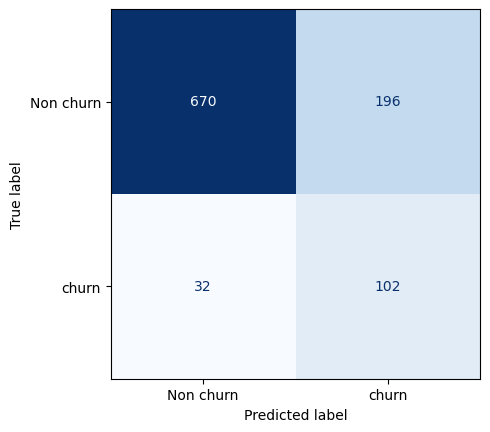

In [21]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_test,
    y_test,
    display_labels=["Non churn", "churn"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
);

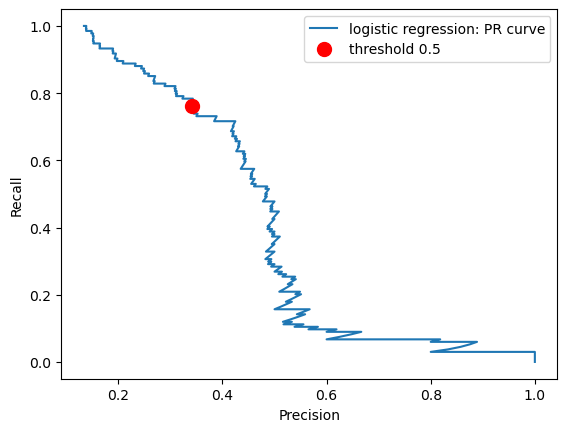

In [22]:
# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(
    y_test, pipe.predict_proba(X_test)[:, 1]
)

plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, pipe.predict(X_test)),
    recall_score(y_test, pipe.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [23]:
# Average precision score 
ap_lr = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("Average precision of logistic regression: {:.3f}".format(ap_lr))

Average precision of logistic regression: 0.457


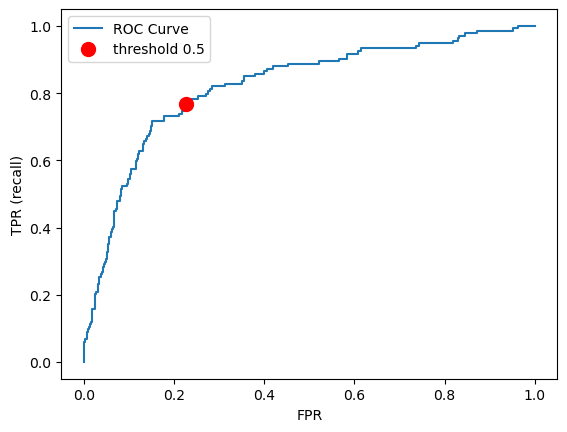

In [24]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [25]:
# AUC Score
roc_lr = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])

print("AUC for LR: {:.3f}".format(roc_lr))

AUC for LR: 0.823


**ANS:** The AUC score can be interpreted as evaluating the ranking of positive examples. Since an AUC of 0.5 means random chance, while an AUC of 1.0 means that all positive points have a higher score than all negative points, our score is in between those 2 margins. We can then interpret this as a pretty good probability and confidence that our model isn't predicting off of random chance.  

<br><br><br><br>

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [26]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### 3.1: Data spitting and exploration 
rubric={points:4}

**Your tasks:**

1. Split the data into train (75%) and test (25%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` to train and test splits. 

In [27]:
train_house_df, test_house_df = train_test_split(housing_df, test_size=0.25, random_state=123)
train_house_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
19995,1.0349,6.0,4.165217,0.982609,734.0,3.191304,36.19,-119.35,0.678
17889,4.7625,13.0,5.265207,1.002433,1087.0,2.644769,37.41,-121.95,1.375
1977,3.5192,9.0,8.747475,1.845118,796.0,2.680135,38.61,-120.44,0.980
6861,2.8672,30.0,4.635616,1.090411,1130.0,3.095890,34.06,-118.13,1.985
11247,4.1276,13.0,4.429936,0.963376,1749.0,2.785032,33.81,-118.00,1.538
...,...,...,...,...,...,...,...,...,...
7763,3.6389,36.0,5.584615,1.115385,490.0,3.769231,33.91,-118.10,1.676
15377,4.5391,14.0,6.016688,1.017972,2436.0,3.127086,33.37,-117.24,1.809
17730,5.6306,5.0,5.958393,1.031564,2435.0,3.493544,37.33,-121.76,2.862
15725,3.8750,44.0,4.739264,1.024540,561.0,1.720859,37.78,-122.44,4.125


In [28]:
train_house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 19995 to 19966
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       15480 non-null  float64
 1   HouseAge     15480 non-null  float64
 2   AveRooms     15480 non-null  float64
 3   AveBedrms    15480 non-null  float64
 4   Population   15480 non-null  float64
 5   AveOccup     15480 non-null  float64
 6   Latitude     15480 non-null  float64
 7   Longitude    15480 non-null  float64
 8   MedHouseVal  15480 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [29]:
train_house_df.describe(include="all")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,3.875935,28.550000,5.421818,1.095860,1437.431137,3.073942,35.626601,-119.568380,2.074085
std,1.900729,12.546577,2.519280,0.492851,1131.575270,10.971330,2.135537,2.001982,1.156051
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990
25%,2.562500,18.000000,4.433750,1.005778,791.000000,2.429227,33.930000,-121.800000,1.203000
50%,3.534300,29.000000,5.228714,1.048412,1173.000000,2.815468,34.250000,-118.490000,1.805000
75%,4.750375,37.000000,6.047297,1.099043,1742.000000,3.278071,37.710000,-118.010000,2.655000
max,15.000100,52.000000,141.909091,34.066667,28566.000000,1243.333333,41.950000,-114.310000,5.000010


In [30]:
X_house_train = train_house_df.drop(columns=["MedHouseVal"])
X_house_test = test_house_df.drop(columns=["MedHouseVal"])

y_house_train = train_house_df["MedHouseVal"]
y_house_test = test_house_df["MedHouseVal"]

housing_preprocessor = StandardScaler() # just need to applying scaling to all since they are numerical values and not categorical

<br><br>

### 3.2 Baseline: Linear Regression 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `sklearn.linear_model.LinearRegression` with default scoring. 
2. What metric is used for scoring by default? 

In [31]:
from sklearn.linear_model import LinearRegression
pipe = make_pipeline(housing_preprocessor, LinearRegression())

housing_scores = cross_validate(
    pipe, X_house_train, y_house_train, return_train_score=True,
)

pd.DataFrame(pd.DataFrame(housing_scores).mean())

,0
fit_time,0.010770
score_time,0.002792
test_score,0.486547
train_score,0.606753


**ANS:** The default metric used for scoring is accuracy

<br><br>

### 3.3 Random Forest Regressor
rubric={points:7}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for two model (`models`) and five evaluation metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [32]:
models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "neg_mean_absolute_percentage_error": "neg_mean_absolute_percentage_error",
}

In [33]:
pipe = make_pipeline(housing_preprocessor, models["Ridge"])

pipe.fit(X_house_train, y_house_train)

ridge_scores = cross_validate(
    pipe, X_house_train, y_house_train, return_train_score=True, scoring=score_types_reg
)

ridge_average = pd.DataFrame(pd.DataFrame(ridge_scores).mean())
# ridge_average
pd.DataFrame(ridge_scores)

,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.009972,0.004989,-0.549963,-0.523218,-0.741595,-0.723338,-0.539838,-0.529527,0.608633,0.603297,-0.321621,-0.315332
1,0.004988,0.003995,-0.539582,-0.524089,-0.734563,-0.723940,-0.544145,-0.530660,0.599232,0.607080,-0.319187,-0.317532
2,0.006981,0.005984,-0.509989,-0.531546,-0.714135,-0.729072,-0.522755,-0.536714,0.616812,0.602606,-0.313360,-0.319989
3,0.008978,0.004984,-0.538532,-0.525259,-0.733847,-0.724748,-0.536827,-0.532926,0.592940,0.607928,-0.322003,-0.316455
4,0.009973,0.004987,-1.255748,-0.523310,-1.120602,-0.723402,-0.536979,-0.529657,0.014994,0.612855,-0.320155,-0.315432


In [34]:
pipe = make_pipeline(housing_preprocessor, models["Random Forest"])

pipe.fit(X_house_train, y_house_train)

random_forest_scores = cross_validate(
    pipe, X_house_train, y_house_train, return_train_score=True, scoring=score_types_reg
)

rf_average = pd.DataFrame(pd.DataFrame(random_forest_scores).mean())
# rf_average
pd.DataFrame(random_forest_scores)

,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,6.162252,0.080784,-0.259690,-0.038391,-0.509598,-0.195935,-0.337346,-0.127410,0.815198,0.970892,-0.194689,-0.071824
1,6.168839,0.072813,-0.272092,-0.036785,-0.521624,-0.191794,-0.338113,-0.125218,0.797907,0.972421,-0.183879,-0.070903
2,8.262936,0.151555,-0.251589,-0.038388,-0.501586,-0.195927,-0.329818,-0.127905,0.810965,0.971301,-0.186667,-0.071981
3,7.125754,0.071808,-0.284197,-0.036629,-0.533101,-0.191388,-0.347556,-0.125163,0.785184,0.972658,-0.197684,-0.070434
4,6.343098,0.078772,-0.273004,-0.036526,-0.522498,-0.191117,-0.338135,-0.125085,0.785856,0.972978,-0.192867,-0.070284


In [35]:
together_df = pd.concat([ridge_average, rf_average], axis = 1)
together_df.columns = ["Ridge", "Random Forest"]
together_df

,Ridge,Random Forest
fit_time,0.008178,6.812576
score_time,0.004988,0.091147
test_neg_mean_squared_error,-0.678763,-0.268114
train_neg_mean_squared_error,-0.525484,-0.037344
test_neg_root_mean_squared_error,-0.808948,-0.517681
train_neg_root_mean_squared_error,-0.724900,-0.193233
test_neg_mean_absolute_error,-0.536109,-0.338194
train_neg_mean_absolute_error,-0.531897,-0.126156
test_r2,0.486522,0.799022
train_r2,0.606753,0.972050


**ANS:** Comparing the 2 models, we can see that overall the RandomForestRegressor is performing much better under most of the scoring metrics used. I'm looking at the test scores as they are the ones that we care about. Since we're using the neg version of the metrics, we can interpret for all of them that a higher score is better. Comparing for all 5 of the metrics used, the Random Forest has higher scores for each.

- test_neg_mean_squared_error: -0.678763 < -0.269128
- test_neg_root_mean_squared_error: -0.808948 < -0.518649
- test_neg_mean_absolute_error: -0.536109 < -0.339664
- test_r2: 0.486522 < 0.798279
- test_neg_mean_absolute_percentage_error: -0.319265 < -0.192081

Compared to our baseline, these models both seem to be performing much better. The test_score for LinearRegression was only 0.486547 which is quite low, but even as we are scoring based off different metrics, these values all seem to show much more success. For example when looking at MAPE, it is decently low for our RandomForestRegressor at only 0.19 which means there is not too much relative error. 

<br><br>

### 3.4 Hyperparameter optimization 
rubric={points:1}

1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose `neg_mean_absolute_percentage_error` as the HParam optimization metric.

2. What was the best `alpha` hyper-parameter found?

In [36]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

pipe = make_pipeline(housing_preprocessor, Ridge())

random_search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5, random_state=123, scoring="neg_mean_absolute_percentage_error"
)

result = random_search.fit(X_house_train, y_house_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.3191159822225338
Best Hyperparameters: {'ridge__alpha': 26.789982776216593}


**ANS:** The best alpha hyperparameter found was 26.789982776216593

<br><br>

### 3.5 Test results
rubric={points:4}

**Your tasks:**

Test the best model (from 3.4) on the test set based on the `neg_mean_absolute_percentage_error` score.

In [37]:
pipe = make_pipeline(housing_preprocessor, Ridge(alpha=26.789982776216593))

pipe.fit(X_house_train, y_house_train)

print(f"Accuracy score: {pipe.score(X_house_test, y_house_test)}")

print(f"MAPE Score: {mean_absolute_percentage_error(y_house_test, pipe.predict(X_house_test))}")

Accuracy score: 0.6078028354348066
MAPE Score: 0.316223945902998


<br><br>

### 3.6 Model interpretation  
rubric={points:4}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Explore coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: 
   - features 
   - coefficients
2. Increasing which feature values would result in higher housing price? 

In [38]:
data = {    
    "features": X_house_train.columns,
    "coefficients": pipe.named_steps["ridge"].coef_.tolist(),
}
coef_df = pd.DataFrame(data)

coef_df

,features,coefficients
0,MedInc,0.834197
1,HouseAge,0.120021
2,AveRooms,-0.270699
3,AveBedrms,0.306563
4,Population,-0.002402
5,AveOccup,-0.042213
6,Latitude,-0.873340
7,Longitude,-0.842722


**ANS:** Since a bigger magnitude corresponds to a greater correlation on the prediction, increasing the feature value of MedInc would result in a higher housing price as it has the largest coefficient (0.834197).

<br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 